# Huggingface Sagemaker - Vision Transformer 

### Image Classification with the `google/vit` on `cifar10`

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [convert features and transform images](#convert-features-and-transform-images)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  

# Introduction

Welcome to our end-to-end binary Image-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with Amazon SageMaker to fine-tune a pre-trained vision transformers on image classification. 

The script and notebook is inspired by [NielsRogges](https://github.com/NielsRogge) example notebook of [Fine-tune the Vision Transformer on CIFAR-10](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb). Niels was also the contributor of the Vision Transformer into `transformers`.


_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

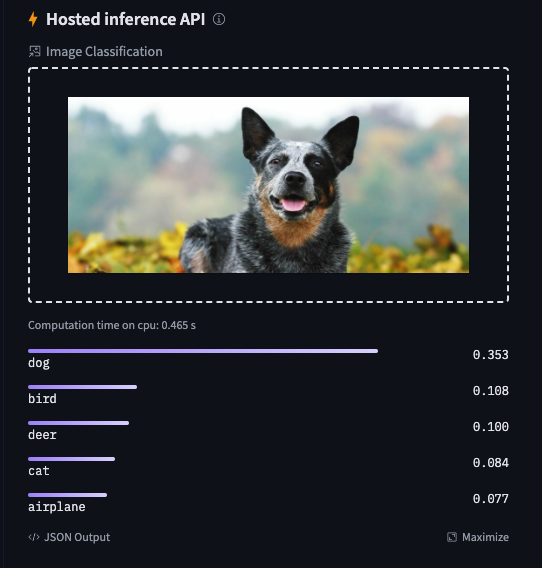

# Development Environment and Permissions 


_**Use at least a `t3.large` instance otherwise preprocessing will take ages.**_

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if not already installed_

In [ ]:
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade

## Permissions

_If you are going to use Sagemaker in a local environment, you need access to an IAM Role with the required permissions for Sagemaker. You can find out more about this [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html)_

In [ ]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

# Preprocessing

We are using the `datasets` library to download and preprocess the `fashion-mnist` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.


_Note from Nils: "that in the ViT paper, the best results were obtained when fine-tuning at a higher resolution. For this, one interpolates the pre-trained absolute position embeddings"._



## Convert Features and transform images

In [ ]:
from transformers import AutoProcessor
from datasets import load_dataset
import numpy as np
from PIL import Image
from random import randint

# dataset used
dataset_name = 'cifar10'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/cifar10'

# FeatureExtractor used in preprocessing
model_name = 'google/vit-base-patch16-224-in21k'

image_processor = AutoProcessor.from_pretrained(model_name)

We are downsampling dataset to make it faster to preprocess.

In [ ]:
# load dataset
train_dataset, test_dataset = load_dataset(dataset_name, 
                                           split=['train[:5000]', 'test[:2000]'])

# display random sample
train_dataset[0]["img"]

In [ ]:
from datasets import Features, Array3D

# we need to extend the features 
features = Features({
    **train_dataset.features,
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

# extractor helper function
def preprocess_images(examples):
    # get batch of images
    images = examples['img']
    inputs = image_processor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

# preprocess dataset
train_dataset = train_dataset.map(preprocess_images, batched=True,features=features)
test_dataset = test_dataset.map(preprocess_images, batched=True,features=features)

# set to torch format for training
train_dataset.set_format('torch', columns=['pixel_values', 'label'])
test_dataset.set_format('torch', columns=['pixel_values', 'label'])

# remove unused column
train_dataet = train_dataset.remove_columns("img")


## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [ ]:
import botocore
from datasets.filesystems import S3FileSystem

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path, num_shards=1)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path, num_shards=1)

print(f"train dataset is uploaded to {training_input_path}")
print(f"test dataset is uploaded to {test_input_path}")



num_train_epochs# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need a `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In an Estimator, we define which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....

```python
/opt/conda/bin/python train.py --num_train_epochs 1 --model_name google/vit-base-patch16-224-in21k --per_device_train_batch_size 16
```

## Creating an Estimator and start a training job

We are defining the hyperparameter `use_auth_token` with our token from huggingface.co/settings to automatically upload our model to the Hugging Face Model Hub afterwards. 
The `train.py` makes us of the `.push_to_hub()` of the Trainer API to automatically upload model to hf.co/models.

In [ ]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'num_train_epochs': 3, # train epochs
                 'per_device_train_batch_size': 16, # batch size
                 'model_name': model_name, # model which will be trained on
                 'use_auth_token': '' # add you API Token to upload the model
                 }

In [ ]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.26',
                            pytorch_version='1.13',
                            py_version='py39',
                            hyperparameters = hyperparameters)

In [ ]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

## Upload to hub

Since we have done the preprocessing in advance we need to upload the `image_processor` separately. You can this by creating a `preprocessor_config.json` file in the UI on huggingface.co or using the `huggingface_hub` python library. 

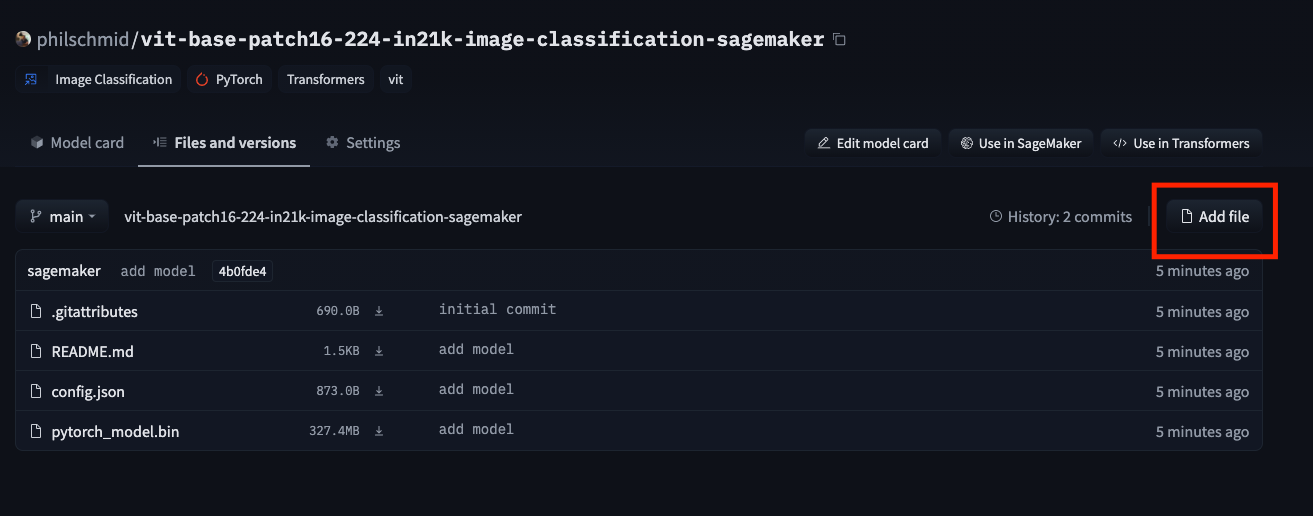

The file needs to contain the configuration of the `image_processor`

In [ ]:
print(image_processor.to_json_string())